<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General" data-toc-modified-id="General-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General</a></span></li><li><span><a href="#Metro" data-toc-modified-id="Metro-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metro</a></span></li><li><span><a href="#Metrobús" data-toc-modified-id="Metrobús-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metrobús</a></span></li><li><span><a href="#ECOBICI" data-toc-modified-id="ECOBICI-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ECOBICI</a></span></li></ul></div>

In [31]:
import requests
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

def momento_dia(hora: int)-> str:
    if hora<=11:
        return "Mañana"
    elif hora<=18:
        return "Tarde"
    else:
        return "Noche"

headers = {
    'cache-control': 'no-cache',
    'content-type': 'application/json',
    'origin': 'https://app.semovi.cdmx.gob.mx',
    'pragma': 'no-cache',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36',
}

json_data = {
    'serie': 'C3325002', # 'C3325010', 
    'anio': '2024',
    'operacion': 'todas',
}

days_of_week = {
    "Monday": "Lunes",
    "Tuesday": "Martes",
    "Wednesday": "Miércoles",
    "Thursday": "Jueves",
    "Friday": "Viernes",
    "Saturday": "Sábado",
    "Sunday": "Domingo"
}

response = requests.post(
    'https://app.semovi.cdmx.gob.mx/micrositio/291-trazabilidad_tarjetas.php',
    headers=headers,
    json=json_data,
)
df = pd.DataFrame(response.json()["data"])
df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True)
df["saldo_final"] = pd.to_numeric(df["saldo_final"])
df["monto"] = pd.to_numeric(df["monto"])
df["dia_semana"] = df["fecha"].dt.day_name().map(days_of_week)
df["momento_dia"] = df["fecha"].dt.hour.apply(momento_dia)
df["day_of_week"] = df["fecha"].dt.day_of_week
orden_dias = list(days_of_week.values())
orden_momento = ["Mañana", "Tarde", "Noche"]

df.head()

,numero,num_serie,organismo,linea,estacion,operacion,monto,saldo_final,fecha,dia_semana,momento_dia,day_of_week
0,1,00000000C3325010,STC,B,PLAZA ARAGÓN,03-VALIDACION,5.0,1.0,2024-06-28 16:45:51,Viernes,Tarde,4
1,2,00000000C3325010,STC,B,PLAZA ARAGÓN,03-VALIDACION,5.0,6.0,2024-06-28 16:45:07,Viernes,Tarde,4
2,3,00000000C3325010,STC,B,ECATEPEC,00-RECARGA,10.0,21.0,2024-06-28 16:03:53,Viernes,Tarde,4
3,4,00000000C3325010,STC,B,ECATEPEC,03-VALIDACION,5.0,11.0,2024-06-28 16:03:40,Viernes,Tarde,4
4,5,00000000C3325010,STC,B,ECATEPEC,03-VALIDACION,5.0,16.0,2024-06-28 16:03:37,Viernes,Tarde,4


In [32]:
df.shape

(375, 12)

In [33]:
df["organismo"].unique()

array(['STC', 'STE', 'METROBÚS'], dtype=object)

In [34]:
df["operacion"].unique()

array(['03-VALIDACION', '00-RECARGA'], dtype=object)

# General

Total de viajes registrados: 375


<AxesSubplot:title={'center':'Viajes por sistema'}, ylabel='organismo'>

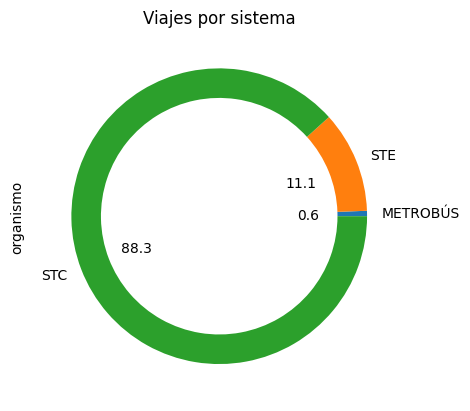

In [35]:
today = datetime.datetime.now()
viajes = df.query("operacion!=['71-FIN DE VIAJE', '00-RECARGA'] & fecha<=@today")
print("Total de viajes registrados:", df.shape[0])
viajes["organismo"].value_counts()[::-1].plot.pie(title="Viajes por sistema", autopct='%.1f',
                   wedgeprops={'width': 0.2})

<AxesSubplot:title={'center':'Viajes por sistema, mensual'}, xlabel='fecha'>

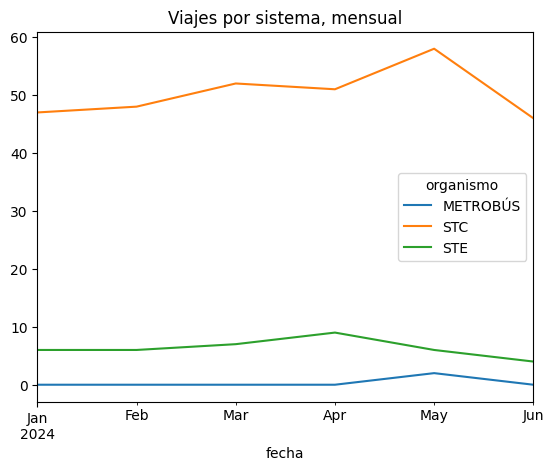

In [36]:
modalidad_tiempo = viajes.groupby([pd.Grouper(key="fecha", freq="1M"), "organismo"])["numero"].count()\
    .unstack()\
    .fillna(0)
modalidad_tiempo.plot(title="Viajes por sistema, mensual")

<AxesSubplot:title={'center':'Viajes totales, por sistema, mensual'}, xlabel='fecha'>

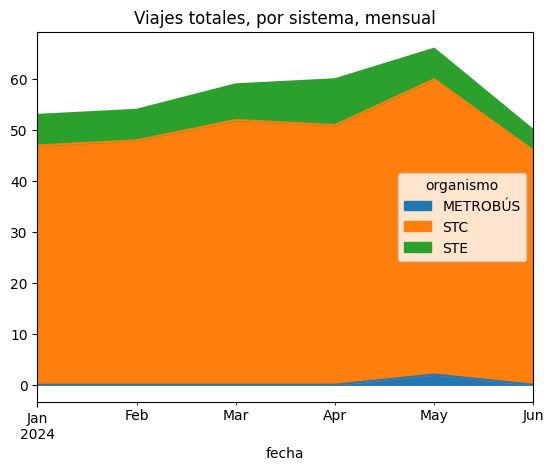

In [37]:
modalidad_tiempo.plot.area(title="Viajes totales, por sistema, mensual")

<AxesSubplot:title={'center':'Viajes por sistema y día de la semana'}, xlabel='dia_semana'>

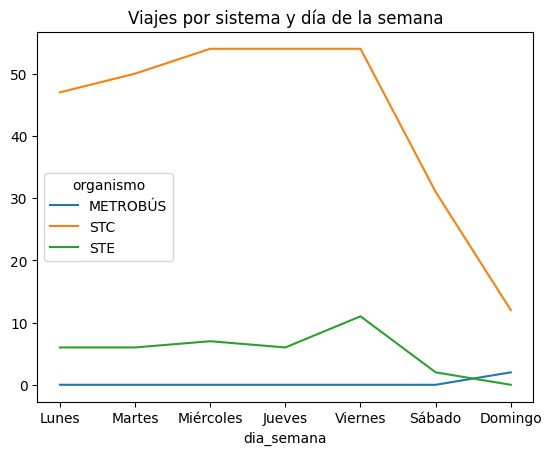

In [38]:
pd.crosstab(viajes["dia_semana"], viajes["organismo"]).loc[orden_dias].plot(
    title="Viajes por sistema y día de la semana"
)

<AxesSubplot:title={'center':'Viajes por sistema y momento de la semana'}, xlabel='organismo'>

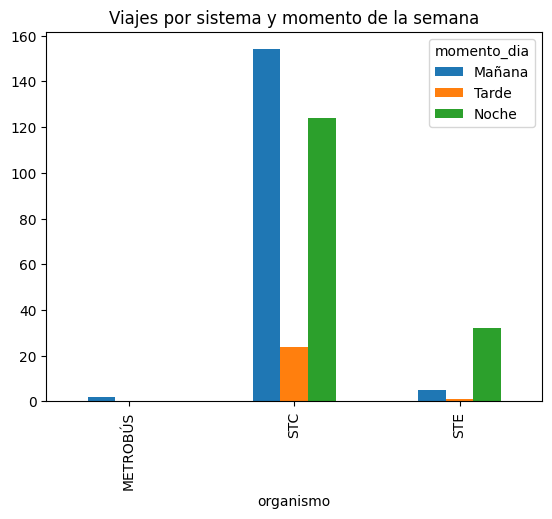

In [39]:
pd.crosstab(viajes["organismo"], viajes["momento_dia"]).loc[:, orden_momento].plot.bar(
    title="Viajes por sistema y momento de la semana"
)

Text(0.5, 1.0, 'Viajes por día de la semana y momento')

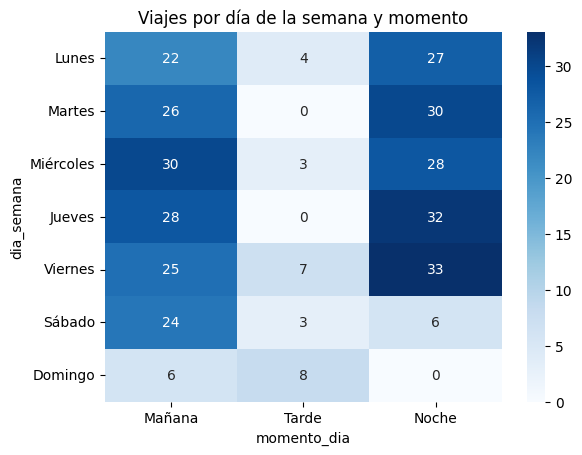

In [40]:
viajes_dia = pd.crosstab(viajes["dia_semana"], viajes["momento_dia"]).loc[orden_dias, orden_momento]
ax = sns.heatmap(viajes_dia, annot=True, cmap="Blues")
ax.set_title("Viajes por día de la semana y momento")

Text(0.5, 1.1, 'Viajes por sistema, según día de la semana y momento del día')

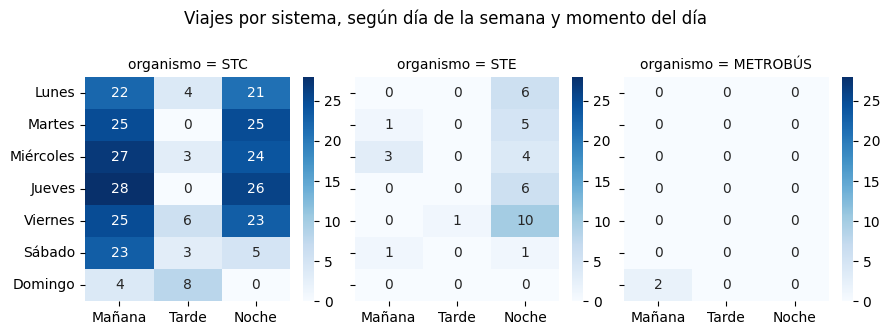

In [41]:
max_value_heatmap_momento_dia = viajes.groupby(["dia_semana", "momento_dia", "organismo"])['numero'].count().max()
def heatmap_momento_dia(data, **kws):
    dia_semana = (pd.DataFrame(index=orden_dias, columns=orden_momento).fillna(0)\
        + pd.crosstab(data["dia_semana"], data["momento_dia"]))\
        .loc[orden_dias, orden_momento]\
        .fillna(0)
    ax = plt.gca()
    sns.heatmap(dia_semana, annot=True, cmap="Blues", ax=ax, vmin=0, vmax=max_value_heatmap_momento_dia, **kws)

g = sns.FacetGrid(viajes, col="organismo", margin_titles=True, despine=False, sharey=True)
g.figure.subplots_adjust(wspace=0, hspace=0)
g.map_dataframe(heatmap_momento_dia)
g.figure.suptitle("Viajes por sistema, según día de la semana y momento del día", y=1.1)

<AxesSubplot:title={'center':'Saldo de tarjeta MI'}, xlabel='fecha'>

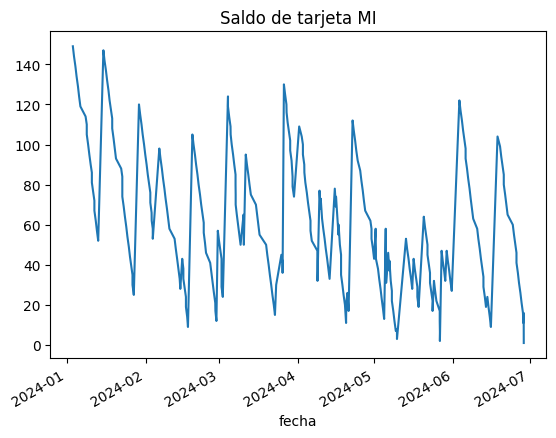

In [42]:
viajes.query("monto!=0").sort_values(["fecha"])\
    .set_index("fecha")["saldo_final"]\
    .plot(title="Saldo de tarjeta MI")

In [43]:
print("Total gastado en viajes:", viajes["monto"].sum())

Total gastado en viajes: 1674.0


<AxesSubplot:title={'center':'Gasto acumulado por sistema de transporte'}, xlabel='fecha'>

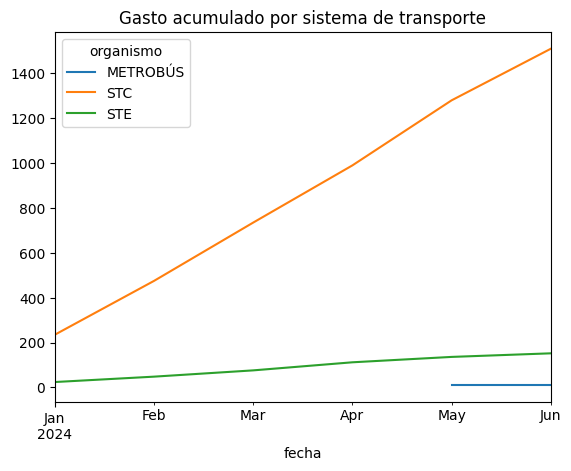

In [44]:
viajes.query("organismo!='ECOBICI'").groupby([pd.Grouper(key="fecha", freq="1M"), "organismo"])["monto"].sum()\
    .unstack()\
    .cumsum()\
    .fillna(method='ffill')\
    .plot(title="Gasto acumulado por sistema de transporte")

# Metro

In [45]:
metro = viajes.query("organismo=='STC'")
metro.head()

,numero,num_serie,organismo,linea,estacion,operacion,monto,saldo_final,fecha,dia_semana,momento_dia,day_of_week
0,1,00000000C3325010,STC,B,PLAZA ARAGÓN,03-VALIDACION,5.0,1.0,2024-06-28 16:45:51,Viernes,Tarde,4
1,2,00000000C3325010,STC,B,PLAZA ARAGÓN,03-VALIDACION,5.0,6.0,2024-06-28 16:45:07,Viernes,Tarde,4
3,4,00000000C3325010,STC,B,ECATEPEC,03-VALIDACION,5.0,11.0,2024-06-28 16:03:40,Viernes,Tarde,4
4,5,00000000C3325010,STC,B,ECATEPEC,03-VALIDACION,5.0,16.0,2024-06-28 16:03:37,Viernes,Tarde,4
5,6,00000000C3325010,STC,12,ZAPATA,03-VALIDACION,5.0,11.0,2024-06-28 12:25:40,Viernes,Tarde,4


In [46]:
print("Total de viajes en metro:", metro.shape[0])

Total de viajes en metro: 302


<AxesSubplot:title={'center':'Viajes por línea del metro'}>

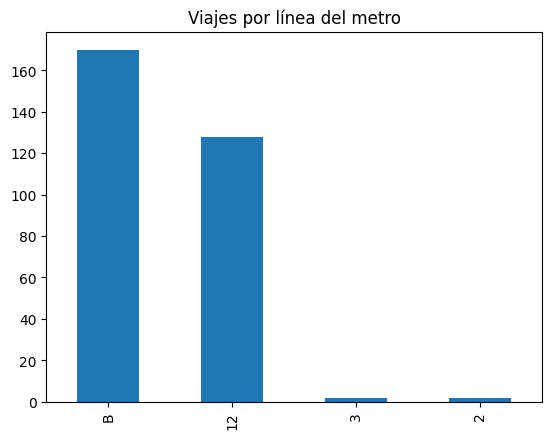

In [47]:
metro["linea"].value_counts().plot.bar(title="Viajes por línea del metro")

<AxesSubplot:title={'center':'Top 10 estaciones de metro más usadas'}>

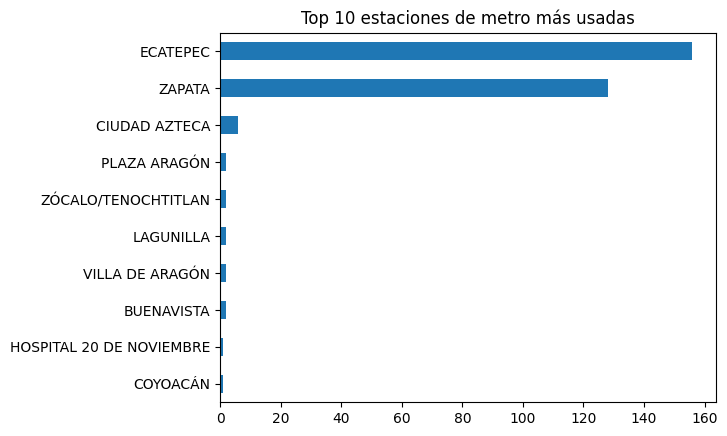

In [48]:
top_n_estaciones = 10
metro["estacion"].value_counts().head(top_n_estaciones)[::-1]\
    .plot.barh(title=f"Top {top_n_estaciones} estaciones de metro más usadas")

<AxesSubplot:title={'center':'Viajes en metro, por semana'}, xlabel='fecha'>

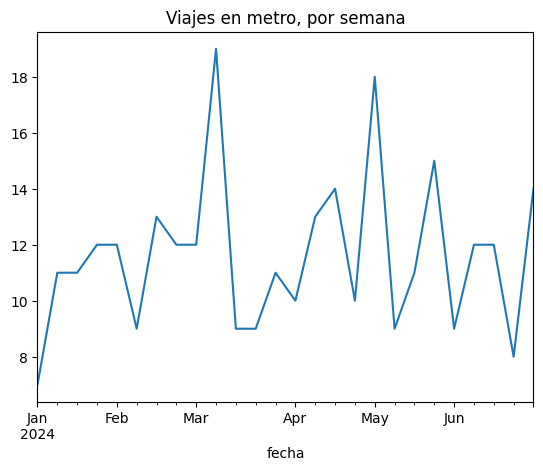

In [49]:
metro.groupby(pd.Grouper(key='fecha', freq="1W"))\
    ["linea"].count().plot(title="Viajes en metro, por semana")

In [50]:
import geopandas as gpd
import folium
# Leer el archivo SHP con GeoPandas
shp_estaciones = 'datos/stcmetro_shp/STC_Metro_estaciones_utm14n.shp'
shp_lineas = 'datos/stcmetro_shp/STC_Metro_lineas_utm14n.shp'
metro_line_colors = ['#F28D1A', '#0A4B3D', '#C6A329', '#C73A43', '#D53B44', '#CB8D43', '#976EAE', '#E75383', '#AD50B8', '#F28C23', '#A29D93', '#91C2A9']

gdf_est = gpd.read_file(shp_estaciones)
lineas = gpd.read_file(shp_lineas)
lineas["style"] = [{"weight": 4, "color": color.lower()} for color in metro_line_colors]

m = folium.Map(location=[19.432608, -99.133209], zoom_start=11, tiles='Cartodb Positron',
)

folium.GeoJson(lineas, style_function=lambda feature: feature["properties"]["style"]).add_to(m)


# Añadir las estaciones al mapa
viajes_estaciones = metro.estacion.str.lower().value_counts().to_dict()
for _, row in gdf_est.loc[lambda x: x["NOMBRE"].str.lower().isin(metro["estacion"].str.lower().unique())].iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius= viajes_estaciones[row['NOMBRE'].lower()] / 10,  # Ajustar el factor de escala según sea necesario
        popup=folium.Popup(f"{row['NOMBRE']} - Viajes: {viajes_estaciones[row['NOMBRE'].lower()]}"),
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)
m

# Metrobús 

In [51]:
metrobus = viajes.query("organismo=='METROBÚS'")
metrobus

,numero,num_serie,organismo,linea,estacion,operacion,monto,saldo_final,fecha,dia_semana,momento_dia,day_of_week
114,115,00000000C3325010,METROBÚS,7,,03-VALIDACION,6.0,41.0,2024-05-05 10:53:28,Domingo,Mañana,6
115,116,00000000C3325010,METROBÚS,7,,03-VALIDACION,6.0,47.0,2024-05-05 10:53:26,Domingo,Mañana,6


<AxesSubplot:title={'center':'Viajes en Metrobús, por línea'}>

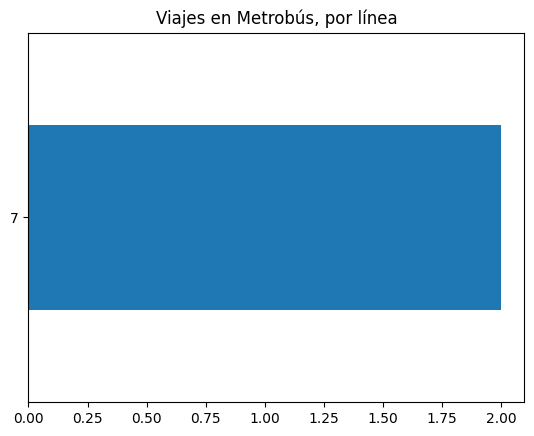

In [52]:
metrobus["linea"].value_counts()[::-1]\
    .plot.barh(title="Viajes en Metrobús, por línea")

<AxesSubplot:title={'center':'Top 10 estaciones de metro más usadas'}>

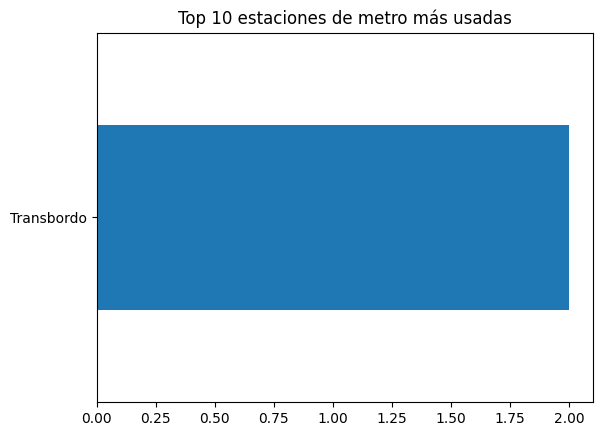

In [53]:
top_n_estaciones = 10
metrobus["estacion"].value_counts()[::-1].head(top_n_estaciones)\
    .rename({"": "Transbordo"}).plot.barh(title=f"Top {top_n_estaciones} estaciones de metro más usadas")

# ECOBICI

In [54]:
ecobici = df.query("organismo=='ECOBICI'")
inicio_viaje = ecobici.query("operacion=='70-INICIO DE VIAJE'")
fin_viaje = ecobici.query("operacion=='71-FIN DE VIAJE'")

In [57]:
#.agg(["min", "mean", "median", "max"])
ecobici.empty

True

In [66]:
if not ecobici.empty:
    inicio_fin = inicio_viaje.merge(fin_viaje.eval('numero=numero+1'), on='numero', suffixes=("_inicio", "_fin"))\
        .filter(["fecha_inicio", "estacion_inicio", "fecha_fin", "estacion_fin", "dia_semana_inicio"])
    inicio_fin["tiempo_viaje"] = (inicio_fin["fecha_fin"] - inicio_fin["fecha_inicio"]).dt.total_seconds() / 60

    matrix_od = pd.crosstab(inicio_fin["estacion_inicio"], inicio_fin["estacion_fin"], margins=True)
    inicios_populares = matrix_od["All"].loc[lambda x: x > 1].index.drop("All")
    fines_populares = matrix_od.loc["All"].loc[lambda x: x > 1].index.drop("All")
    ax = sns.heatmap(matrix_od.loc[inicios_populares, fines_populares], annot=True, cmap="Blues")
    ax.set_title("Rutas de Ecobici más populares")

In [60]:
inicio_fin["tiempo_viaje"].agg(["min", "mean", "median", "max"])

min      NaN
mean     NaN
median   NaN
max      NaN
Name: tiempo_viaje, dtype: float64

In [62]:
if not ecobici.empty:
    matrix_od_tiempo = pd.crosstab(inicio_fin["estacion_inicio"], inicio_fin["estacion_fin"],
                                   values=inicio_fin["tiempo_viaje"], aggfunc='mean')

    ax = sns.heatmap(matrix_od_tiempo.loc[inicios_populares, fines_populares], annot=True, cmap="Blues")
    ax.set_title("Tiempo promedio en rutas de Ecobici más populares")